In [1]:
%cd ..

/home/chickencurry/emb-ml-challenge


In [2]:
import torch
from utils.taylor_pruning import TinyYoloV2WithTaylorRanking, get_channels_to_prune_per_layer, prune_state_dict 
from utils.dataloader import VOCDataLoaderPerson
from utils.loss import YoloLoss
from utils.train_eval import validate, train
from utils.tinyyolov2 import TinyYoloV2Pruned

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# import torch_directml
# device = torch_directml.device()
# print(device)

In [5]:
train_loader = VOCDataLoaderPerson(train=True, batch_size=128, shuffle=True)
val_loader = VOCDataLoaderPerson(train=False, batch_size=1)

In [6]:
load_path = './runs/voc_person_only_new.pt'

In [7]:
net = TinyYoloV2WithTaylorRanking(device, num_classes=1)
net.load_state_dict(torch.load(load_path), strict=False)

criterion = YoloLoss(anchors=net.anchors)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
print(net)

TinyYoloV2WithTaylorRanking(
  (pad): ReflectionPad2d((0, 1, 0, 1))
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 512, kernel_siz

In [8]:
channels_to_prune_per_layer = get_channels_to_prune_per_layer(net, criterion, train_loader, device, 500)

state_dict = torch.load(load_path)
state_dict = prune_state_dict(state_dict, channels_to_prune_per_layer)

  0%|          | 0/17 [00:00<?, ?it/s]/home/chickencurry/miniconda3/envs/torch-directml/lib/python3.8/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 17/17 [02:21<00:00,  8.30s/it]

[0, 0, 0, 0, 3, 18, 145, 334, 0]


100%|██████████| 350/350 [00:23<00:00, 14.88it/s]


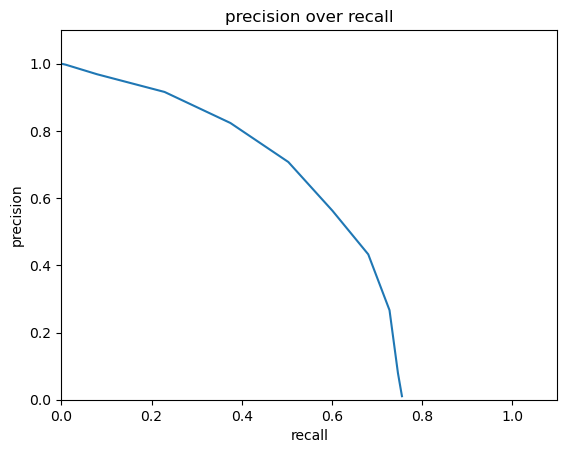

0.5363223118481304

In [9]:
net = TinyYoloV2Pruned(num_classes=1)
net.load_state_dict(state_dict, strict=False)
validate(net, device, val_loader, roc=True)

In [13]:
torch.save(net.state_dict(), "runs/taylor-new/voc_pruned_14.pt")

In [14]:
for key, param in net.named_parameters():
    if any(x in key for x in ['1', '2', '3', '4', '5', '6', '7']):
        param.requires_grad = False
    elif any(x in key for x in ["8", "9"]):
        param.requires_grad = True
params_to_train = filter(lambda x: x.requires_grad, net.parameters())

criterion = YoloLoss(anchors=net.anchors)
optimizer = torch.optim.Adam(params_to_train, lr=0.001)

In [25]:
val_aps, avg_losses = train(net, optimizer, criterion, device, train_loader, val_loader, val_before=False, num_epochs=1)

100%|██████████| 350/350 [00:15<00:00, 22.23it/s]


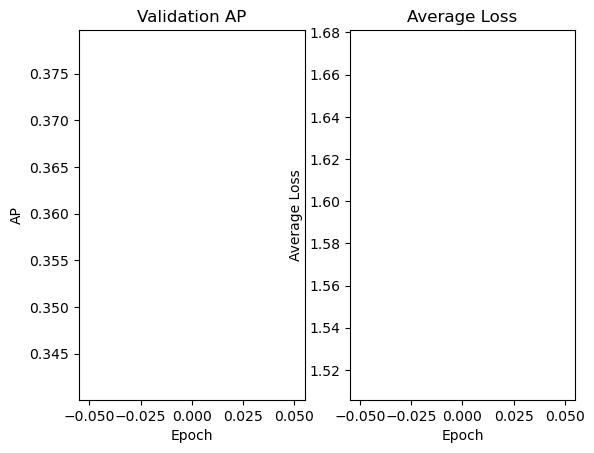

val_aps: [0.35986217784241104]
avg_losses: [1.5934771018869736]


In [26]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(val_aps)
plt.title("Validation AP")
plt.xlabel("Epoch")
plt.ylabel("AP")

plt.subplot(1, 2, 2)
plt.plot(avg_losses)
plt.title("Average Loss")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.show()

print(f"val_aps: {val_aps}")
print(f"avg_losses: {avg_losses}")

In [18]:
validate(net, device, val_loader, roc=True)

 15%|█▍        | 51/350 [00:02<00:13, 22.71it/s]


KeyboardInterrupt: 

In [20]:
torch.save(net.state_dict(), "runs/taylor-new/voc_pruned_14_finetuned.pt")